In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import json
import pycurl
from io import BytesIO
import numpy as np
from datetime import datetime
from datetime import timedelta

In [2]:
pd.options.mode.chained_assignment = None 

# Curve fitting notebook

uncertain parameters are: 


- probability of infection 0.06
- likelihood of awareness 0.1 0.034
- fraction of active contacts 0.54 0.8436
- maximum contacts allowed 32 53

start with probability of infection ...


### Actual infections

In [3]:
with open('cov_data.json') as json_file:
    cov_data = json.load(json_file)

In [4]:
dates = cov_data["RSA"]["Dates"][1:]
cape_town_cases = [int(x) for x in cov_data["RSA"]['City of Cape Town']['Cases']]
#western_cape_cases = [int(x) for x in cov_data["RSA"]['WC']['Cases']]

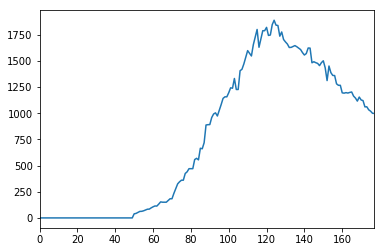

In [5]:
pd.Series([float(x) for x in cov_data["RSA"]['WC']['Hospital']]).plot()

### excess deaths

In [6]:
excess_deaths = pd.read_excel('samrc_excess_deaths_26_08_2020.xlsx', index_col=0)

# Moments of interest: 

1. Deaths
    1. total
    2. peak date
2. Critical cases
    1. max
    2. peak date
3. Recoveries (/ infections)
    1. total
4. New infections
    1. peak date
    2. max
    3. end date
    
### 1 Deaths 

#### A total

In [7]:
print('total excess deaths: ', 'CT: ', int(round(excess_deaths['CPT'].sum())), ' JHN: ', int(round(excess_deaths['JHN'].sum())))

total excess deaths:  CT:  3681  JHN:  3638


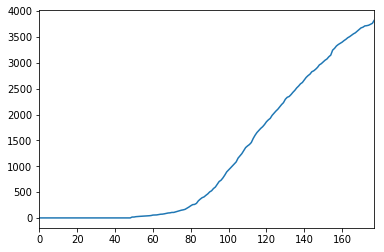

In [8]:
pd.Series([float(x) for x in cov_data["RSA"]['WC']['Deaths']]).plot()

In [9]:
official_deaths = [float(x) for x in cov_data["RSA"]['WC']['Deaths']][-1]
official_deaths

3823.0

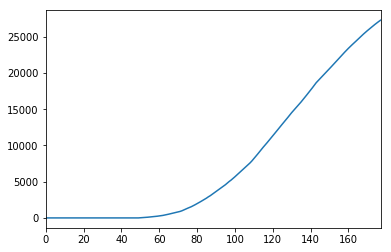

In [10]:
pd.Series([float(x) for x in cov_data["RSA"]['WC']['ICU']]).cumsum().plot()

#### B Peak after first recorded death

In [11]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [12]:
peak_ct = str(excess_deaths['CPT'].idxmax())[:-9]
peak_jb = str(excess_deaths['JHN'].idxmax())[:-9]
first_ct = '2020-03-27' # source: https://www.news24.com/news24/southafrica/news/first-covid-19-deaths-we-mourn-as-a-province-and-country-western-cape-premier-alan-winde-20200327
first_jb = '2020-03-30' # source https://www.news24.com/news24/southafrica/news/coronavirus-79-year-old-man-is-gautengs-first-covid-19-death-20200331

In [13]:
print('peak excess death day: ', 'CT: ', days_between(peak_ct, first_ct), ' JHN: ', days_between(peak_jb, first_jb))

peak excess death day:  CT:  75  JHN:  100


### 2 Critical cases

In [14]:
population_ct = 3740026
population_jhn = 4474829
fraction_WC_in_CT= population_ct / 5823000 # source 2011 Census
fraction_GT_in_JHN = population_jhn / 12272263

In [15]:
ICU_CT = pd.Series([float(x) * fraction_WC_in_CT for x in cov_data["RSA"]['WC']['ICU']])
ICU_CT.index = cov_data["RSA"]["Dates"][:]
ICU_CT.index = [datetime.strptime(x + ' 2020', "%d %b %Y") for x in ICU_CT.index]

#### A Max

In [16]:
print('cape town max critical ', round(max(ICU_CT)))
print('joburg max critical not available ')

cape town max critical  229
joburg max critical not available 


#### B peak date

In [17]:
peak_critical_ct = str(ICU_CT.idxmax())[:-9]
peak_critical_ct

'2020-07-23'

In [18]:
print('peak ICU day: ', 'CT: ', days_between(peak_critical_ct, first_ct), ' JHN: not available')
print('probably wrong because there are now more cases outside of Cape Town')

peak ICU day:  CT:  118  JHN: not available
probably wrong because there are now more cases outside of Cape Town


In [19]:
peak_critical_day_ct = days_between(peak_critical_ct, first_ct)

### 3 Recoveries

#### A Total

#### Cape Town
From WC dashboard: https://coronavirus.westerncape.gov.za/covid-19-dashboard

and from this dashboard: https://www.covid19sa.org/western-cape

In [20]:
recoveries_27Aug = {'Tygerberg': 12102, 'Eastern': 9082, 'Southern': 8590, 'Western': 8430, 
                    'Klipfontein': 8162, 'Mitchels Plain': 7767, 'Khayelitsha': 7688, 'Northern': 6060}
CT_recoveries = sum(recoveries_27Aug.values())
CT_recoveries

67881

#### Johannesburg
From dashboard: https://www.covid19sa.org/gauteng, accessed 27 August

In [21]:
JHN_recoveries = 75310
print('total recoveries in Johannesburg is ', JHN_recoveries)

total recoveries in Johannesburg is  75310


### 4 New infections

Daily changes downloaded from https://www.covid19sa.org/ at August 27th 

In [22]:
gauteng_cases = pd.read_csv('Gauteng_Page 1_Time series.csv')
western_cape_cases = pd.read_csv('Western Cape  Page Design_Page 1_Time series.csv') 
western_cape_cases['Date'] = [datetime.strptime(western_cape_cases['Date'].iloc[x], "%b %d, %Y") for x in range(len(western_cape_cases['Date']))]
gauteng_cases['Date'] = [datetime.strptime(gauteng_cases['Day'].iloc[x], "%b %d, %Y") for x in range(len(gauteng_cases['Day']))]

In [23]:
joburg_cases = pd.Series([0 for x in range(9)] + [x for x in gauteng_cases['Johannesburg']])
city_cases = western_cape_cases[['Date', 'City Of Cape Town']]
city_cases['Johannesburg'] = joburg_cases
city_cases.index = city_cases['Date']
city_cases = city_cases[['City Of Cape Town', 'Johannesburg']].ewm(span = 10).mean()

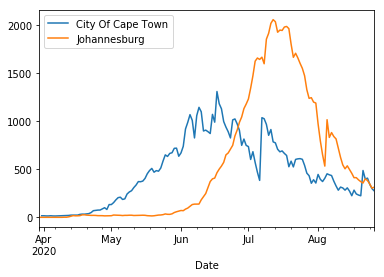

In [24]:
#city_cases.ewm(span = 10).mean().plot()
city_cases.plot()

### A peak date

In [25]:
peak_inf_ct = str(city_cases['City Of Cape Town'].idxmax())[:-9]
peak_inf_jb = str(city_cases['Johannesburg'].idxmax())[:-9]
first_case_ct = str(city_cases['City Of Cape Town'].index[0])[:-9]
first_case_jb = str(city_cases['Johannesburg'].index[11])[:-9]

In [26]:
print('peak new cases day: ', 'CT: ', days_between(peak_inf_ct, first_case_ct), ' JHN: ', days_between(peak_inf_jb, first_case_jb))

peak new cases day:  CT:  79  JHN:  93


### B max

In [27]:
print('peak cases: ', 'CT: ', int(round(city_cases['City Of Cape Town'].max())), ' JHN: ', int(round(city_cases['Johannesburg'].max())))

peak cases:  CT:  1308  JHN:  2056


### C end date

In [28]:
print('not yet')

not yet


### All moments



In [29]:
moments = {'1-A deaths total': [int(round(excess_deaths['CPT'].sum())), int(round(excess_deaths['JHN'].sum()))],
'1-B deaths peak day': [int(days_between(peak_ct, first_ct)), int(days_between(peak_jb, first_jb))],
'2-A critical max': [int(round(max(ICU_CT))), str(np.nan)],
'2-B critical peak day': [int(peak_critical_day_ct), str(np.nan)],
'3 recoveries total': [int(CT_recoveries), int(JHN_recoveries)],
'4-A infections peak day': [int(days_between(peak_inf_ct, first_case_ct)), int(days_between(peak_inf_jb, first_case_jb))],
'4-B max new daily infections': [int(round(city_cases['City Of Cape Town'].max())), int(round(city_cases['Johannesburg'].max()))],
'4-C last new infection': [str(np.nan), str(np.nan)]}

In [30]:
df_moments = pd.DataFrame(moments)
df_moments.index = ['CT', 'JHN']

In [31]:
df_moments = df_moments.transpose()
df_moments

,CT,JHN
1-A deaths total,3681,3638
1-B deaths peak day,75,100
2-A critical max,229,nan
2-B critical peak day,118,nan
3 recoveries total,67881,75310
4-A infections peak day,79,93
4-B max new daily infections,1308,2056
4-C last new infection,nan,nan


# Simulate and study moments

### Change parameters

In [32]:
with open('cape_town/parameters.json') as json_file:
    ct_param_file = json.load(json_file)

In [33]:
with open('johannesburg/parameters.json') as json_file:
    jb_param_file = json.load(json_file)

In [34]:
transmission_new = 0.0164 # tried 5-8 already
ct_param_file['probability_transmission'] = transmission_new
jb_param_file['probability_transmission'] = transmission_new

In [35]:
with open('config_ct.json', 'w') as outfile:
    json.dump(ct_param_file, outfile)

In [36]:
with open('config_jb.json', 'w') as outfile:
    json.dump(jb_param_file, outfile)

### Simulate CT

In [37]:
seed = 3 #ineffective-lockdown

In [38]:
!sabcom simulate -i cape_town -o output_data/cape_town -s 3 -d csv-light -sc ineffective-lockdown -scf config_ct.json

scenario is  ineffective-lockdown
TOTAL RUNTIME 00:01:08.58
Simulation done, check out the output data here: output_data/cape_town


In [39]:
ct_data = pd.read_csv('output_data/cape_town/seed{}quantities_state_time.csv'.format(seed), index_col=0)

In [40]:
ct_data = ct_data * population_ct / ct_param_file['number_of_agents']

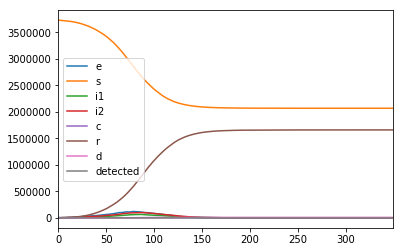

In [41]:
ct_data.plot()

Calculate moments for Cape Town simulation

### Simulate Joburg

In [42]:
!sabcom simulate -i johannesburg -o output_data/johannesburg -s 3 -d csv-light -sc ineffective-lockdown -scf config_jb.json

scenario is  ineffective-lockdown
TOTAL RUNTIME 00:01:06.98
Simulation done, check out the output data here: output_data/johannesburg


In [43]:
jb_data = pd.read_csv('output_data/johannesburg/seed3quantities_state_time.csv', index_col=0)

In [44]:
jb_data = jb_data * population_jhn / jb_param_file['number_of_agents']

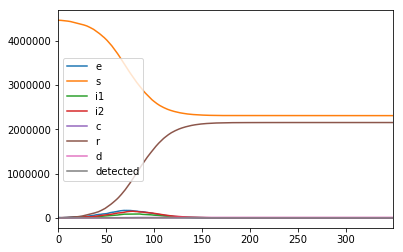

In [45]:
jb_data.plot()

### add to dataset

In [46]:
for df, name in zip([ct_data, jb_data], ['ct_sim', 'jhn_sim']):
    column = []
    #1-A deaths total
    column.append(int(round(df['d'].iloc[-1])))
    #1-B deaths peak day
    column.append(int(round(df['d'].diff().idxmax())))
    #2-A critical max
    column.append(int(round(max(df['c']))))
    #2-B critical peak day
    column.append(int(round(df['c'].idxmax())))
    #3 recoveries total
    column.append(int(round(df['r'].iloc[-1])))
    #4-A infections peak day
    column.append(int(round((df['i1'] + df['i2'] + df['c']).idxmax())))
    #4-B max new daily infections
    column.append(int(round((df['i1'] + df['i2'] + df['c']).max())))
    #4-C last new infection
    column.append(int(round(df['r'].idxmax())))
    df_moments[name] = column

In [47]:
int(round((df['i1'] + df['i2'] + df['c']).max()))

244818

In [48]:
df_moments

,CT,JHN,ct_sim,jhn_sim
1-A deaths total,3681,3638,10734,12619
1-B deaths peak day,75,100,82,109
2-A critical max,229,nan,6171,9889
2-B critical peak day,118,nan,81,87
3 recoveries total,67881,75310,1660385,2153198
4-A infections peak day,79,93,86,78
4-B max new daily infections,1308,2056,172752,244818
4-C last new infection,nan,nan,277,230


## Make excess death figure for curves: 

For deaths we have 98 days... from 2020-05-06 till 2020-08-12

infections... 
deaths

In [49]:
# divide deaths evenly between dates 
# data point 1 and 2 
extended_excess_deaths = {}
for city in ['CPT', 'JHN']:
    excess_death_data = []
    for x in range(len(excess_deaths)-1):
        days = days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
        spread_out_data = [excess_deaths[city].iloc[x] / days for y in range(days)]
        excess_death_data.append(spread_out_data)
    excess_death_extended = [item for sublist in excess_death_data for item in sublist]
    excess_death_extended = pd.Series(excess_death_extended).ewm(span = 10).mean()
    extended_excess_deaths[city] = excess_death_extended

### Start and end date of the simulations

The start date is the first date of the Cape Town simulation while the end date is the last date of the simulation of Joburg. 

In [50]:
# simulation CT starts at 2020-04-17 and ends at 14 March 2021
date1_ct = city_cases['City Of Cape Town'][city_cases['City Of Cape Town'].cumsum() > 310].index[0]

# simulation JHN starts at 2020-06-14 and ends at 
date1_jhn = city_cases['Johannesburg'][city_cases['Johannesburg'].cumsum() > 310].index[0]

In [51]:
start_date = date1_ct 
start_date

Timestamp('2020-04-17 00:00:00')

In [52]:
end_date = date1_jhn + timedelta(days=350)
end_date

Timestamp('2021-04-14 00:00:00')

### Initial cases: 

In [53]:
date1_jhn

Timestamp('2020-04-29 00:00:00')

In [54]:
#western_cape_cases#[western_cape_cases['Date'] <= date1_ct]['City Of Cape Town'].cumsum()

In [55]:
date1_jhn

Timestamp('2020-04-29 00:00:00')

In [56]:
#gauteng_cases#[gauteng_cases['Date'] <= date1_jhn]['Johannesburg'].cumsum()

# Create an all dates series

Use this series to anchor all graphs to the same timeline

In [57]:
extended_excess_deaths['CPT'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['CPT'].index]
extended_excess_deaths['JHN'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['JHN'].index]

In [58]:
# how much to add at start: first date - start date 
# days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
ct_extra_days_start = days_between(str(start_date)[:-9], str(extended_excess_deaths['CPT'].index[0])[:-9]) 
ct_extra_days_end = days_between(str(extended_excess_deaths['CPT'].index[-1])[:-9], str(end_date)[:-9], )

In [59]:
# create time date stamps with timedelta(days=1)
all_dates = [start_date + timedelta(days=x) for x in range(0, ct_extra_days_start)] + [extended_excess_deaths['CPT'].index[0] + timedelta(days=x) for x in range(len(extended_excess_deaths['CPT']))] + [extended_excess_deaths['CPT'].index[-1] + timedelta(days=x) for x in range(1, ct_extra_days_end + 1)]#.iloc[-1]

# Extend data sets to make them fit on one graph:


### determine how much to: 
- add at the start
- add at the end 
### Then add 0s on both sides

start with excess death empirical 

# Create an all dates series

Use this series to anchor all graphs to the same timeline

Add: 

- excess deaths JB
- simulation JB
- simulation CT 

In [60]:
# generate series with index all_dates and 0 if not in own index and x if in index
def generate_new_series(old_series):
    new_series = []
    for d in all_dates:
        if d in old_series.index:
            new_series.append(old_series.loc[d])
        else:
            new_series.append(0)
    return new_series

In [61]:
# generate jb and ct sim data
jb_sim_deaths = jb_data['d'].diff().ewm(span = 10).mean()
ct_sim_deaths = ct_data['d'].diff().ewm(span = 10).mean()

In [62]:
# index is start date to end date.... ct 
ct_sim_deaths.index = [date1_ct + timedelta(days=x) for x in range(0, len(ct_sim_deaths))]

In [63]:
jb_sim_deaths.index = [date1_jhn + timedelta(days=x) for x in range(0, len(jb_sim_deaths))]

In [64]:
len(ct_sim_deaths)

350

In [65]:
master_data = pd.DataFrame({
    'dates': all_dates,
    'excess_d_ct': generate_new_series(extended_excess_deaths['CPT']),
    'excess_d_jhn': generate_new_series(extended_excess_deaths['JHN']),
    'sim_d_ct':generate_new_series(ct_sim_deaths),
    'sim_d_jhn':generate_new_series(jb_sim_deaths),
})

In [66]:
#all_dates
death_data = pd.DataFrame(master_data)
death_data.index = death_data['dates']
death_data = death_data[['excess_d_ct', 'sim_d_ct', 'sim_d_jhn', 'excess_d_jhn']]

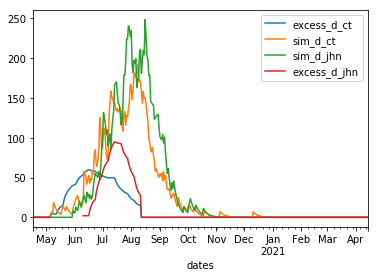

In [67]:
death_data.plot()

### Curve fitting: 

create function to simulate the model on seed 3, record output ... deaths..... and score using the new cost function 

In [83]:
from helpers.estimation import ls_cost_function, constrNM
import click
import os
import time
import logging
import random
import pickle
from sabcom.helpers import generate_district_data, what_informality
from sabcom.environment import Environment

In [85]:
def runner(environment, initial_infections, seed, data_folder='output_data/',
           data_output=False, calculate_r_naught=False):
    """
    This function is used to run / simulate the model.

    :param environment: contains the parameters and agents, Environment object
    :param initial_infections: contains the Wards and corresponding initial infections, Pandas DataFrame
    :param seed: used to initialise the random generators to ensure reproducibility, int
    :param data_folder:  string of the folder where data output files should be created
    :param data_output:  can be 'csv', 'network', or False (for no output)
    :param calculate_r_naught: set to True to calculate the R0 that the model produces given a single infected agent
    :return: environment object containing the updated agents, Environment object
    """
    # set monte carlo seed
    np.random.seed(seed)
    random.seed(seed)

    # create sets for all agent types
    dead = []
    recovered = []
    critical = []
    sick_with_symptoms = []
    sick_without_symptoms = []
    exposed = []
    susceptible = [agent for agent in environment.agents]

    # 4 Initialisation of infections
    # here either a fixed initial agent can be infected once to calculate R0
    if calculate_r_naught:
        initial_infected = []
        chosen_agent = environment.agents[environment.parameters['init_infected_agent']]
        chosen_agent.status = 'e'
        initial_infected.append(chosen_agent)
        exposed.append(chosen_agent)
        susceptible.remove(chosen_agent)
    # otherwise infect a set of agents based on the locations of observed infections
    else:
        initial_infections = initial_infections.sort_index()
        cases = [x for x in initial_infections['Cases']]
        probabilities_new_infection_district = [float(i) / sum(cases) for i in cases]

        initial_infected = []
        environment.newly_detected_cases[0] += round(len(environment.parameters['total_initial_infections']) *
                                                     environment.parameters["perc_infections_detects"])
        # select districts with probability
        chosen_districts = list(np.random.choice(environment.districts,
                                                 len(environment.parameters['total_initial_infections']),
                                                 p=probabilities_new_infection_district))
        # count how often a district is in that list
        chosen_districts = {distr: min(len(environment.district_agents[distr]),
                                       chosen_districts.count(distr)) for distr in chosen_districts}

        for district in chosen_districts:
            # infect appropriate number of random agents
            chosen_agents = np.random.choice(environment.district_agents[district], chosen_districts[district],
                                             replace=False)
            for chosen_agent in chosen_agents:
                chosen_agent.status = 'i2' # TODO debug! used to be 'e'
                # give exposed days a random value to avoid an unrealistic wave of initial infections
                chosen_agent.sick_days = np.random.randint(0, environment.parameters['symptom_days']) #TODO used to be exposed days
                sick_with_symptoms.append(chosen_agent)
                susceptible.remove(chosen_agent)

    for t in range(environment.parameters["time"]):
        # Check if the health system is not overburdened
        if len(critical) / len(environment.agents) > environment.parameters["health_system_capacity"]:
            health_overburdened_multiplier = environment.parameters["no_hospital_multiplier"]
        else:
            health_overburdened_multiplier = 1.0

        # 5 update infection status of all agents
        for agent in exposed + sick_without_symptoms + sick_with_symptoms + critical:  # + recovered if SEIRS model
            if agent.status == 'e':
                agent.exposed_days += 1
                # some agents will become infectious but do not show agents while others will show symptoms
                if agent.exposed_days > environment.parameters["exposed_days"]:
                    if np.random.random() < environment.parameters["probability_symptomatic"]:
                        agent.status = 'i2'
                        exposed.remove(agent)
                        sick_with_symptoms.append(agent)
                    else:
                        agent.status = 'i1'
                        exposed.remove(agent)
                        sick_without_symptoms.append(agent)

            if agent.status == 'i1':
                agent.asymptomatic_days += 1
                # asymptomatic agents all recover after some time
                if agent.asymptomatic_days > environment.parameters["asymptom_days"]:
                    # calculate R0 here if the first agent recovers
                    if calculate_r_naught and agent in initial_infected:
                        print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                        return agent.others_infects_total

                    agent.status = 'r'
                    sick_without_symptoms.remove(agent)
                    recovered.append(agent)

            elif agent.status == 'i2':
                agent.sick_days += 1
                # some symptomatic agents recover
                if agent.sick_days > environment.parameters["symptom_days"]:
                    if np.random.random() < environment.parameters["probability_critical"][agent.age_group]:
                        agent.status = 'c'
                        sick_with_symptoms.remove(agent)
                        critical.append(agent)
                    else:
                        # calculate R0 here if the first agent recovers
                        if calculate_r_naught and agent in initial_infected:
                            print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                            return agent.others_infects_total
                        agent.status = 'r'
                        sick_with_symptoms.remove(agent)
                        recovered.append(agent)

            elif agent.status == 'c':
                agent.critical_days += 1
                # some agents in critical status will die, the rest will recover
                if agent.critical_days > environment.parameters["critical_days"]:
                    # calculate R0 here if the first agent recovers or dies
                    if calculate_r_naught and agent in initial_infected:
                        print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                        return agent.others_infects_total

                    if np.random.random() < (environment.parameters["probability_to_die"][
                                agent.age_group] * health_overburdened_multiplier):
                        agent.status = 'd'
                        critical.remove(agent)
                        dead.append(agent)
                    else:
                        agent.status = 'r'
                        critical.remove(agent)
                        recovered.append(agent)

            elif agent.status == 'r':
                agent.days_recovered += 1
                if np.random.random() < (environment.parameters["probability_susceptible"] * agent.days_recovered):
                    recovered.remove(agent)
                    agent.status = 's'
                    susceptible.append(agent)

        # 6 New infections
        for agent in sick_without_symptoms + sick_with_symptoms:
            agent.others_infected = 0

            # find indices from neighbour agents
            household_neighbours = [x for x in environment.network.neighbors(agent.name) if
                                    environment.agents[x].household_number == agent.household_number and
                                    environment.agents[x].district == agent.district]
            other_neighbours = [x for x in environment.network.neighbors(agent.name) if
                                environment.agents[x].household_number != agent.household_number or
                                environment.agents[x].district != agent.district]

            # depending on lockdown policies, the amount of non-household contacts an agent can visit is reduced
            visiting_r_contacts_multiplier = environment.parameters["visiting_recurring_contacts_multiplier"][t]
            informality_term_contacts = (1 - visiting_r_contacts_multiplier) * agent.informality

            planned_contacts = int(round(len(other_neighbours
                                             ) * (visiting_r_contacts_multiplier + informality_term_contacts)))

            # by gathering max contacts
            gathering_max_contacts = environment.parameters['gathering_max_contacts'][t]
            if gathering_max_contacts != float('inf'):
                individual_max_contacts = int(round(gathering_max_contacts * (1 + agent.informality)))
            else:
                individual_max_contacts = gathering_max_contacts

            if planned_contacts > individual_max_contacts:
                other_neighbours = random.sample(other_neighbours, individual_max_contacts)
            else:
                other_neighbours = random.sample(other_neighbours, planned_contacts)

            # Next, combine household neighbours with other neighbours
            neighbours_from_graph = household_neighbours + other_neighbours

            # find the corresponding agents and add them to a list to infect
            # if the agent is aware it will limit its contact to only household contacts
            likelihood_awareness = environment.parameters['likelihood_awareness'][t]
            if agent.status in environment.parameters['aware_status'] and \
                    np.random.random() < likelihood_awareness * (1 - agent.informality):
                neighbours_to_infect = [environment.agents[idx] for idx in household_neighbours]
            # otherwise the agent will interact with all neighbours from graph
            else:
                neighbours_to_infect = [environment.agents[idx] for idx in neighbours_from_graph]

            # let these agents be infected (with random probability
            physical_distancing_multiplier = environment.parameters["physical_distancing_multiplier"][t]
            for neighbour in neighbours_to_infect:
                if neighbour.household_number == agent.household_number and neighbour.district == agent.district:
                    informality_term_phys_dis = (1 - physical_distancing_multiplier)
                else:
                    informality_term_phys_dis = (1 - physical_distancing_multiplier) * agent.informality

                if neighbour.status == 's' and np.random.random() < (
                        environment.parameters['probability_transmission'] * (
                        physical_distancing_multiplier + informality_term_phys_dis)):
                    neighbour.status = 'e'
                    susceptible.remove(neighbour)
                    exposed.append(neighbour)
                    agent.others_infected += 1
                    agent.others_infects_total += 1

                    # add to detected agents with probability
                    if np.random.random() < environment.parameters["perc_infections_detects"]:
                        environment.newly_detected_cases[t] += 1

        if data_output == 'network':
            environment.infection_states.append(environment.store_network())
        elif data_output == 'csv':
            environment.write_status_location(t, seed, data_folder)
        elif data_output == 'csv-light':
            # save only the total quantity of agents per category
            for key, quantity in zip(['e', 's', 'i1', 'i2', 'c', 'r', 'd', 'detected'], [exposed,
                                                                                         susceptible,
                                                                                         sick_without_symptoms,
                                                                                         sick_with_symptoms,
                                                                                         critical, recovered, dead,
                                                                                         [x for x in range(environment.newly_detected_cases[t])]]):
                environment.infection_quantities[key].append(len(quantity))

    return environment

In [69]:
def simulate(**kwargs):
    """Simulate the model"""
    # format arguments
    seed = kwargs.get('seed')
    output_folder_path = kwargs.get('output_folder_path')

    input_folder_path = kwargs.get('input_folder_path')

    inititialisation_path = os.path.join(input_folder_path, 'initialisations')

    seed_path = os.path.join(inititialisation_path, 'seed_{}.pkl'.format(seed))

    if not os.path.exists(seed_path):
        click.echo(seed_path + ' not found', err=True)
        click.echo('Error: specify a valid seed')
        return

    data = open(seed_path, "rb")
    list_of_objects = pickle.load(data)
    environment = list_of_objects[0]

    # update optional parameters
    if kwargs.get('days'):
        max_time = environment.parameters['time']  # you cannot simulate longer than initialised
        environment.parameters['time'] = min(kwargs.get('days'), max_time)
        click.echo('Time has been set to {}'.format(environment.parameters['time']))
        logging.debug('Time has been set to {}'.format(environment.parameters['time']))

    if kwargs.get('probability_transmission'):
        environment.parameters['probability_transmission'] = kwargs.get('probability_transmission')
        click.echo('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))
        logging.debug('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))

    if kwargs.get('visiting_recurring_contacts_multiplier'):
        environment.parameters['visiting_recurring_contacts_multiplier'] = [kwargs.get('visiting_recurring_contacts_multiplier') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))
        logging.debug(
            'Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))

    if kwargs.get('likelihood_awareness'):
        environment.parameters['likelihood_awareness'] = [kwargs.get('likelihood_awareness') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness'][0]))
        logging.debug(
            'Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness'][0]))

    if kwargs.get('gathering_max_contacts'):
        environment.parameters['gathering_max_contacts'] = [kwargs.get('gathering_max_contacts') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts'][0]))
        logging.debug(
            'Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts'][0]))
        
    if kwargs.get('initial_infections'):
        environment.parameters['initial_infections'] = [x for x in range(round(int(kwargs.get('initial_infections'))))]
        click.echo('Initial infections have been set to {}'.format(len(environment.parameters['initial_infections'])))
        logging.debug('Initial infections have been set to {}'.format(len(environment.parameters['initial_infections'])))

    if kwargs.get('sensitivity_config_file_path'):
        # open file
        config_path = kwargs.get('sensitivity_config_file_path')
        if not os.path.exists(config_path):
            click.echo(config_path + ' not found', err=True)
            click.echo('Error: specify a valid path to the sensitivity config file')
            return
        else:
            with open(config_path) as json_file:
                config_file = json.load(json_file)

                for param in config_file:
                    environment.parameters[param] = config_file[param]

    # transform input data to general district data for simulations
    district_data = generate_district_data(environment.parameters['number_of_agents'], path=input_folder_path)

    # set scenario specific parameters
    scenario = kwargs.get('scenario', 'no-intervention')
    print('scenario is ', scenario)
    if scenario == 'no-intervention':
        environment.parameters['likelihood_awareness'] = [
            0.0 for x in environment.parameters['likelihood_awareness']]
        environment.parameters['visiting_recurring_contacts_multiplier'] = [
            1.0 for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        environment.parameters['gathering_max_contacts'] = [
            float('inf') for x in environment.parameters['gathering_max_contacts']]
        environment.parameters['physical_distancing_multiplier'] = [
            1.0 for x in environment.parameters['physical_distancing_multiplier']]
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'lockdown':
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'ineffective-lockdown':
        environment.parameters['informality_dummy'] = 1.0

    # log parameters used after scenario called
    for param in environment.parameters:
        logging.debug('Parameter {} has the value {}'.format(param, environment.parameters[param]))

    for agent in environment.agents:
        agent.informality = what_informality(agent.district, district_data
                                             ) * environment.parameters["informality_dummy"]

    initial_infections = pd.read_csv(os.path.join(input_folder_path, 'f_initial_cases.csv'), index_col=0)

    # save csv light or network data
    data_output_mode = kwargs.get('data_output_mode', 'csv-light')  # default output mode is csv_light
    environment.parameters["data_output"] = data_output_mode

    environment = runner(environment=environment, initial_infections=initial_infections, seed=int(seed),
                         data_folder=output_folder_path,
                         data_output=data_output_mode)

    return pd.DataFrame(environment.infection_quantities)['d'] * (3700000 / 100000)

In [109]:
# score 
def ls_model_performance(input_params):
    """
    Simple function calibrate uncertain model parameters
    :param input_parameters: list of input parameters
    :return: cost
    """
    transmission_probability = input_params[0]
    emp_dead_curve = death_data['excess_d_ct']
    
    # run model with parameters.
    sim_dead_curve = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                              scenario='ineffective-lockdown', probability_transmission=transmission_probability,
                              initial_infections=input_params[1])
    
    # lenghten sim_dead_curve to fit empircal one TODO update
    sim_dead_curve = pd.Series([x * 3740026 / 100000 for x in sim_dead_curve])
    sim_dead_curve = sim_dead_curve.diff().ewm(span = 10).mean()
    sim_dead_curve.index = [date1_ct + timedelta(days=x) for x in range(0, len(sim_dead_curve))]
    sim_dead_curve = generate_new_series(sim_dead_curve)

    # calculate the cost
    cost = ls_cost_function(emp_dead_curve, sim_dead_curve)
    return cost

In [110]:
# left right bounds + initial R_0 for optimizer 
LB = [0.0155, 250.0]
UB = [0.0170, 450.0]
initial_transm = 0.0164
initial_infections = 276.0

output = constrNM(ls_model_performance, [initial_transm, initial_infections], LB, UB, maxiter=3, full_output=True)

Transmission probability has been set to 0.0164
Initial infections have been set to 275
scenario is  ineffective-lockdown
Transmission probability has been set to 0.01662628940336211
Initial infections have been set to 275
scenario is  ineffective-lockdown
Transmission probability has been set to 0.0164
Initial infections have been set to 296
scenario is  ineffective-lockdown
Transmission probability has been set to 0.01615807976189977
Initial infections have been set to 296
scenario is  ineffective-lockdown
Transmission probability has been set to 0.015925738124138427
Initial infections have been set to 308
scenario is  ineffective-lockdown
Transmission probability has been set to 0.015925738124138427
Initial infections have been set to 285
scenario is  ineffective-lockdown


In [90]:
output

{'fopt': 81.8490111588699,
 'iter': 3,
 'funcalls': 6,
 'warnflag': 2,
 'xopt': array([1.68133674e-02, 2.60627721e+02]),
 'allvecs': None}

In [91]:
output['xopt'][0]

0.01681336735687316

In [92]:
round(int(output['xopt'][1]))

260

In [97]:
deaths = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                              scenario='ineffective-lockdown', probability_transmission=output['xopt'][0],
                              initial_infections=round(int(output['xopt'][1])))

Transmission probability has been set to 0.01681336735687316
Initial infections have been set to 260
scenario is  ineffective-lockdown


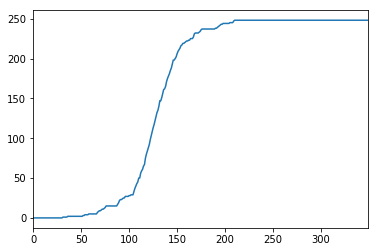

In [112]:
deaths.plot()

In [94]:
deaths = deaths.diff().ewm(span = 10).mean()
deaths.index = [date1_ct + timedelta(days=x) for x in range(0, len(deaths))]
deaths = generate_new_series(deaths)

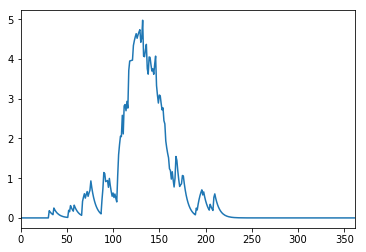

In [95]:
pd.Series(deaths).plot()

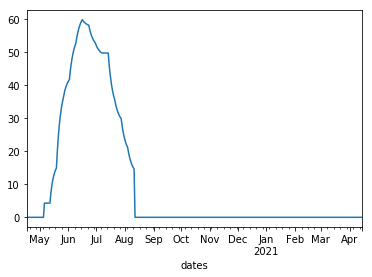

In [76]:
death_data['excess_d_ct'].plot()